In [1]:
%matplotlib widget
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import uproot
from IPython.display import Image
from Utils import *
import sys 
Swan = True if "swan" or "cern" in sys.executable else False

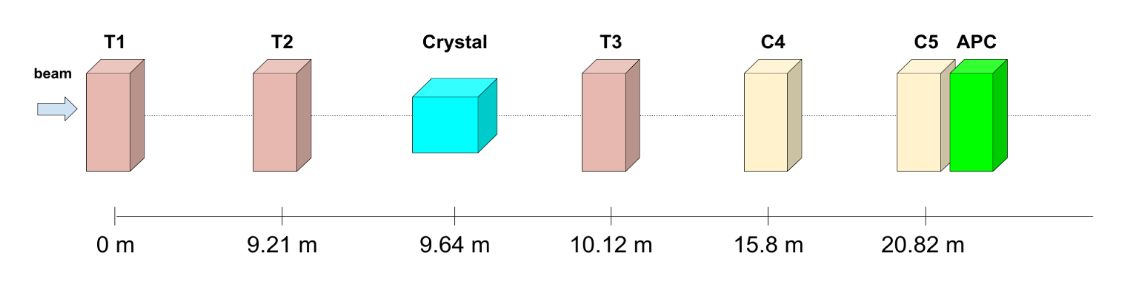

In [2]:
Image(filename='./experimental setup.png',width=600, height=400)

In [3]:
d_tele12 = 921                   ##cm
d_tele2crist = 43                ##cm
d_tele23 = 91                    ##cm
d_tele13 = d_tele12 + d_tele23   ##cm
BCnear= True
if BCnear:
    d_tele1BC2 = 1580 ##cm
else:
    d_tele1BC2 = 2082   ##cm
##da mettere nel file config

In [4]:
config_file = r"./config.json"

with open(config_file, "r") as f:
            dizi = json.load(f)
#nRun = 720218
#nRun = 720251
nRun = 720374 #after installing the near detector

dizi =  {
    "RunAllignment": nRun,
    "d_12": d_tele12, #cm
    "d_23": d_tele23, #cm
    "d_2crist": d_tele2crist, #cm
    "d_1crist": dizi["d_12"]+dizi["d_2crist"],
    "d_13": d_tele12 + d_tele23, 
    "d_tele1BC2": d_tele1BC2,
    }

with open(config_file, "w") as f:
            json.dump(dizi, f, indent=4)
        
#RUN ON SWAN OR LOCALLY?
if Swan:
    data_dir = r"/eos/project/i/insulab-como/testBeam/TB_2023_08_H8_SELDOM/HDF5"
else:
    data_dir = "."

config_file = r"./config.json"

data_path = f'{data_dir}/run{nRun}.h5'


with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
    print(hf.keys())
    hf["xpos"].shape
    keys = list(hf.keys())
    for k in hf.keys():
        comand = f'{k} = np.array(hf["{k}"])'
        # print(comand)
        exec(comand)
        

<KeysViewHDF5 ['ievent', 'info_plus', 'nstrip', 'xinfo', 'xpos']>


In [5]:
logic = (xpos > 0) & (xpos < 10)
logic2 = logic.all(axis = 1)

xpos = xpos[logic2]
print(np.shape(xpos))

offset12, div12 = align(xpos[:,0], xpos[:,1], xpos[:,2], xpos[:,3], dizi["d_12"], True, n_sigma=1.5)
offset13, div13 = align(xpos[:,0], xpos[:,1], xpos[:,4], xpos[:,5], dizi["d_13"], True, n_sigma=1.5)
offset1BC1, divBC1 = align(xpos[:,0], xpos[:,1], xpos[:,6], xpos[:,7], dizi["d_tele1BC2"], True, n_sigma=1)
#offset1BC2, divBC2 = align(xpos[:,0], xpos[:,1], xpos[:,8], xpos[:,9], dizi["d_tele1BC2"], True)


new_values = {
    "data_dir": data_dir,
    "offset_x2": offset12[0],
    "offset_y2": offset12[1],
    "offset_x3": offset13[0],
    "offset_y3": offset13[1],
    "offset_x4": offset1BC1[0],
    "offset_y4": offset1BC1[1],
    #"offset_x5": offset1BC2[0],
    #"offset_y5": offset1BC2[1],
    "div_12x": div12[0],
    "div_12y": div12[1],
    "div_13x": div13[0],
    "div_13y": div13[1],
    "div_BC1x": divBC1[0],
    "div_BC1y": divBC1[1],
    #"div_BC2x": divBC2[0],
    #"div_BC2y": divBC2[1]
}

dizi.update(new_values)

xpos[:,2] -= dizi['offset_x2']
xpos[:,3] -= dizi['offset_y2']
xpos[:,4] -= dizi['offset_x3']
xpos[:,5] -= dizi['offset_y3']
xpos[:,6] -= dizi['offset_x4']
xpos[:,7] -= dizi['offset_y4']
#xpos[:,8] -= dizi['offset_x5']
#xpos[:,9] -= dizi['offset_y5']

(24171, 8)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
fig, axes = plt.subplots(4,2)
fig.subplots_adjust(hspace=.4)
fig.set_size_inches(10,10)

for i in range(4):
    ax = axes[i,0]
    if i<3:
        ax.set_title(f"Tele {i+1} - x proj")
    else:
        ax.set_title(f"BC {i+1} - x proj")
    
#    h, c = np.histogram(xpos[:,2*i], bins = 384)
    h, c = np.histogram(xpos[:,2*i], bins = 50)
    c = c[:-1] + (c[1]+c[0])/2
    
    ax.plot(c, h, ds = 'steps-mid')
    
    ax.set_xlabel("x pos [cm]")
    ax.set_ylabel("Counts")
    ax.grid()
    
    ax = axes[i,1]
    if i<3:
        ax.set_title(f"Tele {i+1} - y proj")
    else:
        ax.set_title(f"BC {i+1} - y proj")
    
#    h, c = np.histogram(xpos[:,2*i+1], bins = 384)
    h, c = np.histogram(xpos[:,2*i+1], bins = 50)
    c = c[:-1] + (c[1]+c[0])/2
    
    ax.plot(c, h, ds = 'steps-mid', c = "orange")    
    
    ax.set_xlabel("y pos [cm]")
    ax.set_ylabel("Counts")
    ax.grid()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
lstCoord = ["x1","y1","x2","y2","x3","y3","x4", "y4"]#, "x5", "y5"]

fig, ax = plt.subplots(1,int(len(xpos[1,:])))
fig.set_size_inches(10,4)
# fig.subplots_adjust(hspace = 0.9)

for i in range(int(len(xpos[1,:]))):
    # print(f'{i+1}-{(len(xpos[1,:]))}')
    if i < 3:
        ax[i].hist2d(xpos[:,i],xpos[:,i+2],bins=200)
        ax[i].set_xlabel(lstCoord[i],fontsize = 14)
        ax[i].set_ylabel(lstCoord[i+2], fontsize = 14)   
    elif i >= 3:
        ax[i].hist2d(xpos[:,i],xpos[:,i-4],bins=200)
        ax[i].set_xlabel(lstCoord[i],fontsize = 14)
        ax[i].set_ylabel(lstCoord[i-4], fontsize = 14)   
plt.show()

###aggiungere un WARNING se sono anticorrelate

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
only12div = True
if only12div:
    deltaX_12 = xpos[:,2]-xpos[:,0]# tele 2-1
    deltaY_12 = xpos[:,3]-xpos[:,1]# tele 2-1

    theta_12_x = np.arctan(deltaX_12/d_tele12) * 1e6 # urad
    theta_12_y = np.arctan(deltaY_12/d_tele12) * 1e6 # urad

    theta12 = [theta_12_x, theta_12_y]
    thetaLbl = ["x", "y"]
    num_bins = 100

    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(10,7)

    titles = [fr"$\theta_X in 12$ ", fr"$\theta_Y in12 $"]
    popt_list12 =[]
    for i in range(2):
        h, bins = np.histogram(theta12[i], bins = num_bins, range=[-800, 800])
        binc = bins[:-1] + (bins[1] - bins[0]) / 2

        p0 = (np.max(h), binc[np.argmax(h)], np.std(theta12[i]))
        cond = h>0
        popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
        popt_list12.append(popt[1])
        ax[i].plot(binc, h, ds = "steps-mid", lw = 1,
                   label = fr"$\theta_{thetaLbl[i]}$")

        ax[i].plot(binc, myGauss(binc, *popt), ls = "--", lw = .7, c = "red", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} $\mu rad$)")

        ax[i].grid()
        ax[i].set_title(titles[i])
        ax[i].set_ylabel("Entries", fontsize = 14)    
        ax[i].set_xlabel(r"$\theta$ [$\mu rad$]",fontsize = 14)

        ax[i].legend(fontsize = 14)

        print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} $\mu rad$")


    # Creazione del plot
    ax[2].hist2d(theta12[0], theta12[1], bins=num_bins, range=[[-200,200],[-200,200]])#, cmap="viridis")

    # Etichette degli assi
    ax[2].grid()
    ax[2].set_xlabel('thetax')
    ax[2].set_ylabel('thetay')


    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

La divergenza in x vale 39.81 $\mu rad$
La divergenza in y vale 28.82 $\mu rad$


In [9]:
x1, y1 = xpos[:,0], xpos[:,1]
x2, y2 = xpos[:,2], xpos[:,3]
x3, y3 = xpos[:,4], xpos[:,5]
x4, y4 = xpos[:,6], xpos[:,7]
#x5, y5 = xpos[:,8], xpos[:,9]

rot = xinfo[:,0]


In [10]:
theta_12_x = np.arctan((x2-x1)/d_tele12) * 1e6 # urad
theta_12_y = np.arctan((y2-y1)/d_tele12) * 1e6 # urad

theta_13_x = np.arctan((x3-x1)/d_tele13) * 1e6 # urad
theta_13_y = np.arctan((y3-y1)/d_tele13) * 1e6 # urad

theta12 = [theta_12_x, theta_12_y]
theta13 = [theta_13_x, theta_13_y]

thetaLbl = ["x","y","_","x","y","_"]
num_bins = 250

fig, ax = plt.subplots(2,3)
fig.set_size_inches(10,7)
fig.subplots_adjust(wspace=.4,hspace=.8)
ax=ax.flatten()
print(ax.shape)
titles = [fr"$\theta_X in 12$ ", fr"$\theta_Y in 12 $","_",fr"$\theta_X in 13$ ", fr"$\theta_Y in 13 $","_"]
for i in range(5):
    if i== 2 or i==5:
        continue
    if i<2 :
        h, bins = np.histogram(theta12[i], bins = 300, )
        binc = bins[:-1] + (bins[1] - bins[0]) / 2
        p0 = (np.max(h), binc[np.argmax(h)], np.std(theta12[i]))
    elif i>2:
        h, bins = np.histogram(theta13[i-3], bins = 250, )
        binc = bins[:-1] + (bins[1] - bins[0]) / 2
        p0 = (np.max(h), binc[np.argmax(h)], np.std(theta13[i-3]))

    cond = h>0
    popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    ax[i].plot(binc, h, ds = "steps-mid", c = "green", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    
    # ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} mrad)")
    ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} urad)")
    
    ax[i].grid()
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Entries", fontsize = 11)    
    ax[i].set_xlabel(r"$\theta$ [mrad]",fontsize = 11)
    
    ax[i].legend(fontsize = 11)
    
    # print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} mrad")
    if i<2:
        print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad in 2")
    else:
        print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad in 3")


# Creazione del plot
ax[2].hist2d(theta12[0], theta12[1], bins=num_bins)
ax[5].hist2d(theta13[0], theta13[1], bins=num_bins)

for a in ax: 
    # a.set_xlim((-0.5,+0.5)) #mrad
    a.set_xlim((-300,+300))

# Etichette degli assi
ax[2].grid()
ax[2].set_xlabel('thetax')
ax[2].set_ylabel('thetay')
ax[2].set_ylim((-300,+300))
ax[5].grid()
ax[5].set_xlabel('thetax')
ax[5].set_ylabel('thetay')
ax[5].set_ylim((-300,+300))

        

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(6,)
La divergenza in x vale 39.54 urad in 2
La divergenza in y vale 28.68 urad in 2
La divergenza in x vale 39.62 urad in 3
La divergenza in y vale 28.49 urad in 3


In [11]:
with open(config_file, "w") as f:
            json.dump(dizi, f, indent=4)

In [12]:
dizi

{'RunAllignment': 720374,
 'd_12': 921,
 'd_23': 91,
 'd_2crist': 43,
 'd_1crist': 964,
 'd_13': 1012,
 'd_tele1BC2': 1580,
 'data_dir': '/eos/project/i/insulab-como/testBeam/TB_2023_08_H8_SELDOM/HDF5',
 'offset_x2': 0.07806817598347049,
 'offset_y2': -0.3215607824343533,
 'offset_x3': 0.11587483304062503,
 'offset_y3': -0.5105463416185236,
 'offset_x4': -0.038727162032854784,
 'offset_y4': 4.21592233820313,
 'div_12x': 3.9158902242421664e-05,
 'div_12y': 2.856314570199142e-05,
 'div_13x': 3.8990252314782414e-05,
 'div_13y': 2.7872540269441723e-05,
 'div_BC1x': 3.758456156762604e-05,
 'div_BC1y': 2.7299236033839342e-05}